SOURCES:  
https://www.bonaccorso.eu/2017/08/19/hodgkin-huxley-spiking-neuron-model-python/   
https://github.com/swharden/pyHH/blob/master/dev/concept4.py

In [6]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')

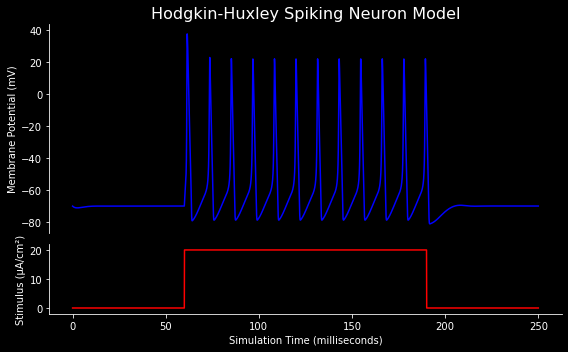

In [7]:
class HHModel:
    """The HHModel tracks conductances of 3 channels to calculate Vm"""

    class Gate:
        """The Gate object manages a channel's kinetics and open state"""
        alpha, beta, state = 0, 0, 0

        def update(self, deltaTms):
            alphaState = self.alpha * (1-self.state)
            betaState = self.beta * self.state
            self.state += deltaTms * (alphaState - betaState)

        def setInfiniteState(self):
            self.state = self.alpha / (self.alpha + self.beta)

    ENa, EK, EKleak = 115, -12, 10.6
    gNa, gK, gKleak = 120, 36, 0.3
    m, n, h = Gate(), Gate(), Gate()
    Cm = 1

    def __init__(self, startingVoltage=0):
        self.Vm = startingVoltage
        self.UpdateGateTimeConstants(startingVoltage)
        self.m.setInfiniteState()
        self.n.setInfiniteState()
        self.n.setInfiniteState()

    def UpdateGateTimeConstants(self, Vm):
        """Update time constants of all gates based on the given Vm"""
        self.n.alpha = .01 * ((10-Vm) / (np.exp((10-Vm)/10)-1))
        self.n.beta = .125*np.exp(-Vm/80)
        self.m.alpha = .1*((25-Vm) / (np.exp((25-Vm)/10)-1))
        self.m.beta = 4*np.exp(-Vm/18)
        self.h.alpha = .07*np.exp(-Vm/20)
        self.h.beta = 1/(np.exp((30-Vm)/10)+1)

    def UpdateCellVoltage(self, stimulusCurrent, deltaTms):
        """calculate channel currents using the latest gate time constants"""
        INa = np.power(self.m.state, 3) * self.gNa * \
            self.h.state*(self.Vm-self.ENa)
        IK = np.power(self.n.state, 4) * self.gK * (self.Vm-self.EK)
        IKleak = self.gKleak * (self.Vm-self.EKleak)
        Isum = stimulusCurrent - INa - IK - IKleak
        self.Vm += deltaTms * Isum / self.Cm

    def UpdateGateStates(self, deltaTms):
        """calculate new channel open states using latest Vm"""
        self.n.update(deltaTms)
        self.m.update(deltaTms)
        self.h.update(deltaTms)

    def Iterate(self, stimulusCurrent=0, deltaTms=0.05):
        self.UpdateGateTimeConstants(self.Vm)
        self.UpdateCellVoltage(stimulusCurrent, deltaTms)
        self.UpdateGateStates(deltaTms)


if __name__ == "__main__":
    hh = HHModel()
    pointCount = 5000
    voltages = np.empty(pointCount)
    times = np.arange(pointCount) * 0.05
    stim = np.zeros(pointCount)
    stim[1200:3800] = 20  # create a square pulse

    for i in range(len(times)):
        hh.Iterate(stimulusCurrent=stim[i], deltaTms=0.05)
        voltages[i] = hh.Vm
        # note: you could also plot hh's n, m, and k (channel open states)

    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                 gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(times, voltages - 70, 'b')
    ax1.set_ylabel("Membrane Potential (mV)")
    ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontsize=16)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(bottom=False)

    ax2.plot(times, stim, 'r')
    ax2.set_ylabel("Stimulus (µA/cm²)")
    ax2.set_xlabel("Simulation Time (milliseconds)")
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    plt.margins(0, 0.1)
    plt.tight_layout()
    plt.show()

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
# Set random seed (for reproducibility)
np.random.seed(1000)
# Start and end time (in milliseconds)
tmin = 0.0
tmax = 50.0
# Average potassium channel conductance per unit area (mS/cm^2)
gK = 36.0
# Average sodoum channel conductance per unit area (mS/cm^2)
gNa = 120.0
# Average leak channel conductance per unit area (mS/cm^2)
gL = 0.3
# Membrane capacitance per unit area (uF/cm^2)
Cm = 1.0
# Potassium potential (mV)
VK = -12.0
# Sodium potential (mV)
VNa = 115.0
# Leak potential (mV)
Vl = 10.613
# Time values
T = np.linspace(tmin, tmax, 10000)
# Potassium ion-channel rate functions
def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)
def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)
# Sodium ion-channel rate functions
def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)
def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)
def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)
def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)
# n, m, and h steady-state values
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))
def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))
def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))
# Input stimulus
def Id(t):
    if 0.0 < t < 1.0:
        return 150.0
    elif 10.0 < t < 11.0:
        return 50.0
    return 0.0
# Compute derivatives
def compute_derivatives(y, t0):
    dy = np.zeros((4,))
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    dy[0] = (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    return dy
# State (Vm, n, m, h)
Y = np.array([0.0, n_inf(), m_inf(), h_inf()])
# Solve ODE system
# Vy = (Vm[t0:tmax], n[t0:tmax], m[t0:tmax], h[t0:tmax])
Vy = odeint(compute_derivatives, Y, T)

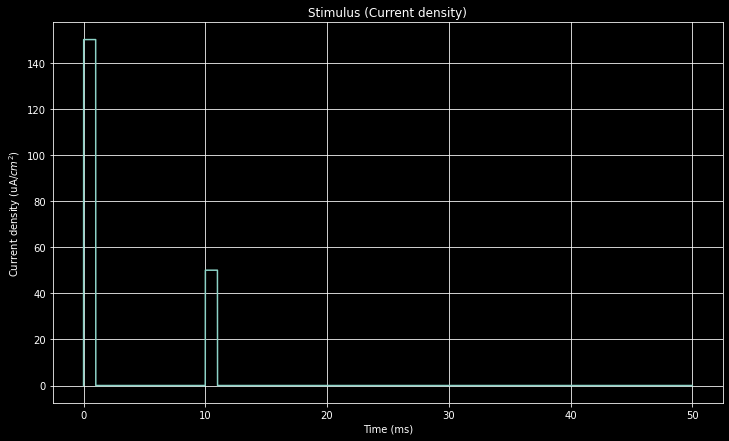

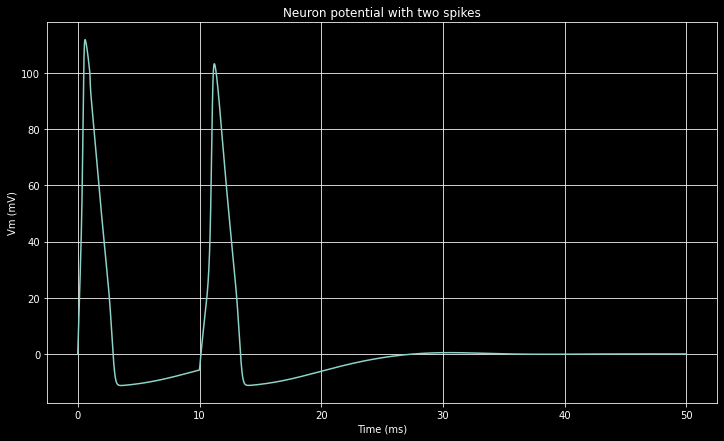

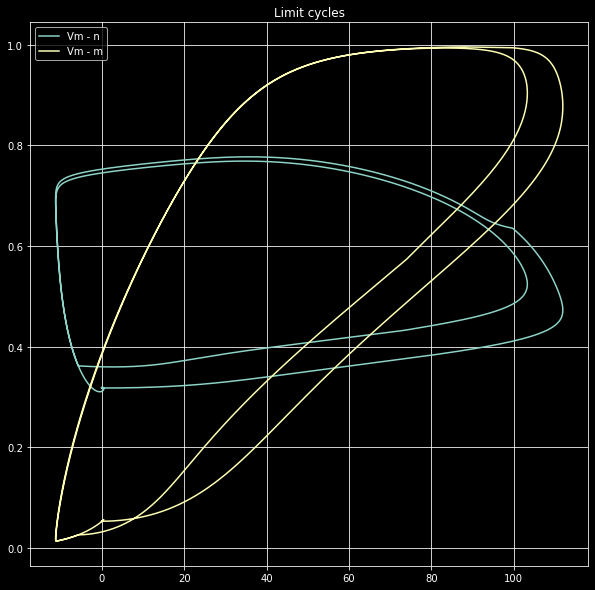

In [10]:
# Input stimulus
Idv = [Id(t) for t in T]
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(T, Idv)
ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'Current density (uA/$cm^2$)')
ax.set_title('Stimulus (Current density)')
plt.grid()
# Neuron potential
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(T, Vy[:, 0])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neuron potential with two spikes')
plt.grid()
# Trajectories with limit cycles
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(Vy[:, 0], Vy[:, 1], label='Vm - n')
ax.plot(Vy[:, 0], Vy[:, 2], label='Vm - m')
ax.set_title('Limit cycles')
ax.legend()
plt.grid()